# LSTM

## Caricamento del dataframe

In [59]:
import torch
from torch import nn
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torch.nn as nn

import numpy as np
import pandas as pd
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score

from torch.utils.tensorboard import SummaryWriter

from scipy.stats import mode

from modules.pytorchtools import EarlyStopping 

import os
import shutil
import glob

main_folder = "../data"

folder = "./runs/LSTM_1"

try:
    shutil.rmtree(folder, ignore_errors=True)
except:
    pass

try:
    os.mkdir(folder)
except:
    pass

writer = SummaryWriter(folder)

## Train - Validation - Test

In [60]:
LABELS = [
    "No_action",
    "Prendi",
    "Rilascia",
    "Premi"
]

In [61]:
class2idx = {
    "No_action": 0,
    "Prendi": 1,
    "Rilascia": 2,
    "Premi": 3
}

idx2class = {v: k for k, v in class2idx.items()}

In [62]:
def join_csv(folder_set, filename):
    csv:list = []

    for file in glob.glob(folder_set + "/*.csv"):
        csv.append(file)

    columns:bool = True
    with open(filename, "w") as f:
        for fcsv in csv:
            with open(fcsv, "r") as fc:
                if columns:
                    f.writelines(fc.readlines())
                    columns = False
                fc.readline()
                f.writelines(fc.readlines())

In [63]:
def create_set(folder_set) -> list:
    csv:list = []
    for file in glob.glob(folder_set + "/*.csv"):
        csv.append(file)
    columns:bool = True
    colname = []
    data = []
    target = []
    for fcsv in csv:
        data_video = []
        target_video = []
        with open(fcsv, "r") as fc:
            if columns:
                colname = [(name) for name in fc.readline().split(",")]
                colname[-1] = colname[-1][:-1]
                columns = False
            else:
                fc.readline()
            for row in fc.readlines():
                split_row = row.split(",")
                data_video.append(split_row[:-1])
                target_video.append(class2idx[split_row[-1][:-1]])
        data.append(np.array(data_video).astype(float))
        target.append(np.array(target_video).astype(int))
    return (np.array(data, dtype=object), np.array(target, dtype=object), colname)

In [64]:
def create_set(folder_set):
    csv:list = []
    for file in glob.glob(folder_set + "/*.csv"):
        csv.append(file)
    data = []
    target = []
    for fcsv in csv:
        data_video = pd.read_csv(fcsv, usecols = [i for i in range(156)]).to_numpy()
        target_video = pd.read_csv(fcsv, usecols = ["TARGET"])
        target_video["TARGET"].replace(class2idx, inplace=True)
        data.append(data_video)
        target.append(target_video.to_numpy())
    return (np.array(data, dtype=object), np.array(target, dtype=object))

In [65]:
folder_set = [[main_folder + "/train_set", main_folder + "/train.csv"], [main_folder + "/test_set", main_folder + "/test.csv"], [main_folder + "/val_set", main_folder + "/val.csv"]]

train_array, train_label_array = create_set(folder_set[0][0])
test_array, test_label_array = create_set(folder_set[1][0])
val_array, val_label_array = create_set(folder_set[2][0])

In [66]:
print(train_array.shape, train_label_array.shape, test_array.shape, test_label_array.shape, val_array.shape, val_label_array.shape)

(38,) (38,) (10,) (10,) (8,) (8,)


In [67]:
for elem, label in zip(train_array, train_label_array):
    print(elem.shape, label.shape)
    print(type(elem), type(label))

(1115, 156) (1115, 1)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(1009, 156) (1009, 1)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(1070, 156) (1070, 1)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(3598, 156) (3598, 1)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(1975, 156) (1975, 1)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(788, 156) (788, 1)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(1867, 156) (1867, 1)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(1100, 156) (1100, 1)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(1489, 156) (1489, 1)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(2210, 156) (2210, 1)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(1680, 156) (1680, 1)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(2045, 156) (2045, 1)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(1164, 156) (1164, 1)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(1434, 156) (1434, 1)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(842, 156) (842, 1)
<c

In [68]:
folder_set = [[main_folder + "/train_set", main_folder + "/train.csv"], [main_folder + "/test_set", main_folder + "/test.csv"], [main_folder + "/val_set", main_folder + "/val.csv"]]

for f_set, filename in folder_set:
    join_csv(f_set, filename)
    
train = pd.read_csv(main_folder + "/train.csv")
test = pd.read_csv(main_folder + "/test.csv")
val = pd.read_csv(main_folder + "/val.csv")

train['TARGET'].replace(class2idx, inplace=True)
test['TARGET'].replace(class2idx, inplace=True)
val['TARGET'].replace(class2idx, inplace=True)

In [69]:
train.head()

,RIGHT_Palm_x,RIGHT_Palm_y,RIGHT_Palm_z,LEFT_Palm_x,LEFT_Palm_y,LEFT_Palm_z,RIGHT_ThumbTip_x,RIGHT_ThumbTip_y,RIGHT_ThumbTip_z,LEFT_ThumbTip_x,...,LEFT_PinkyMetacarpal_x,LEFT_PinkyMetacarpal_y,LEFT_PinkyMetacarpal_z,RIGHT_Wrist_x,RIGHT_Wrist_y,RIGHT_Wrist_z,LEFT_Wrist_x,LEFT_Wrist_y,LEFT_Wrist_z,TARGET
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [70]:
test.head()

,RIGHT_Palm_x,RIGHT_Palm_y,RIGHT_Palm_z,LEFT_Palm_x,LEFT_Palm_y,LEFT_Palm_z,RIGHT_ThumbTip_x,RIGHT_ThumbTip_y,RIGHT_ThumbTip_z,LEFT_ThumbTip_x,...,LEFT_PinkyMetacarpal_x,LEFT_PinkyMetacarpal_y,LEFT_PinkyMetacarpal_z,RIGHT_Wrist_x,RIGHT_Wrist_y,RIGHT_Wrist_z,LEFT_Wrist_x,LEFT_Wrist_y,LEFT_Wrist_z,TARGET
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [71]:
val.head()

,RIGHT_Palm_x,RIGHT_Palm_y,RIGHT_Palm_z,LEFT_Palm_x,LEFT_Palm_y,LEFT_Palm_z,RIGHT_ThumbTip_x,RIGHT_ThumbTip_y,RIGHT_ThumbTip_z,LEFT_ThumbTip_x,...,LEFT_PinkyMetacarpal_x,LEFT_PinkyMetacarpal_y,LEFT_PinkyMetacarpal_z,RIGHT_Wrist_x,RIGHT_Wrist_y,RIGHT_Wrist_z,LEFT_Wrist_x,LEFT_Wrist_y,LEFT_Wrist_z,TARGET
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [72]:
print(train.shape[0], test.shape[0], val.shape[0])

56125 11860 9656


Si separano le colonne delle features dall'etichetta.

In [73]:
train_label = train["TARGET"]
test_label = test["TARGET"]
val_label = val["TARGET"]

del train["TARGET"]
del test["TARGET"]
del val["TARGET"]

## Visualizzazione della distribuzione delle classi in Train, Val e Test

In [74]:
def get_class_distribution(obj):
    count_dict = {
        "No_action": 0,
        "Prendi": 0,
        "Rilascia": 0,
        "Premi": 0,
    }
    
    for i in obj:
        if i == 0: 
            count_dict['No_action'] += 1
        elif i == 1: 
            count_dict['Prendi'] += 1
        elif i == 2: 
            count_dict['Rilascia'] += 1
        elif i == 3: 
            count_dict['Premi'] += 1            
        else:
            print("Check classes.")
            
    return count_dict

Text(0.5, 1.0, 'Class Distribution in Test Set')

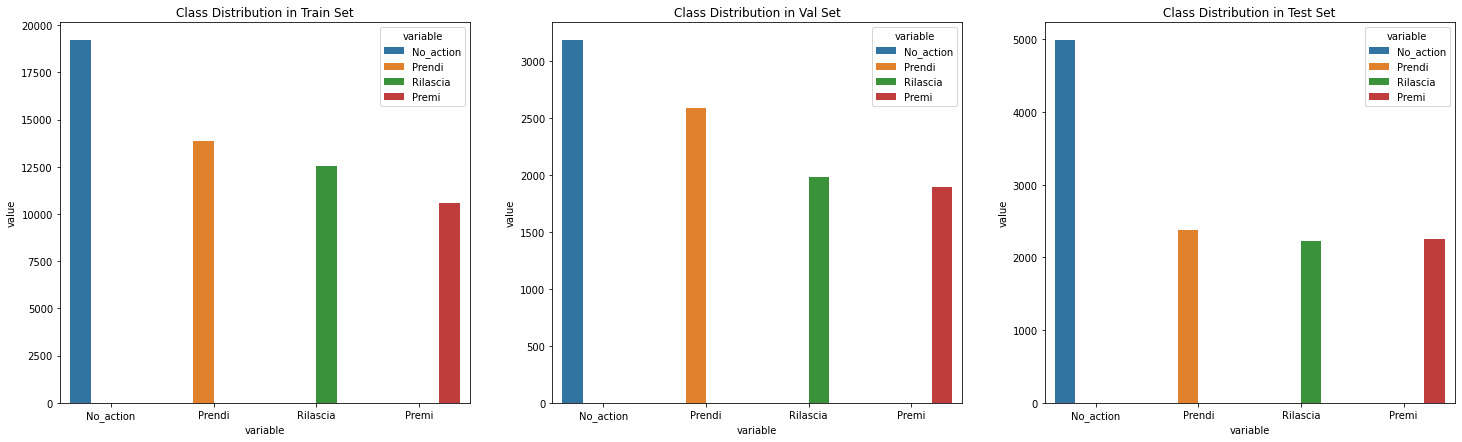

In [75]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,7))
# Train
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(train_label)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')
# Validation
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(val_label)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')
# Test
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(test_label)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[2]).set_title('Class Distribution in Test Set')

In [76]:
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [77]:
window_size = 1

In [78]:
def create_dataset(dataset, target, window_size = 2):
    dataX, dataY = [], []
    for i in range(len(dataset) - window_size):
        dataX.append(dataset[i:(i + window_size)])
        dataY.append(target[i:(i + window_size + 1)].values[0])
    return np.array(dataX), np.array(dataY)

In [79]:
train_X, train_Y = create_dataset(train, train_label, window_size)
train_dataset_w = ClassifierDataset(torch.from_numpy(train_X).float(), torch.from_numpy(train_Y).long())

test_X, test_Y = create_dataset(test, test_label, window_size)
test_dataset_w = ClassifierDataset(torch.from_numpy(test_X).float(), torch.from_numpy(test_Y).long())

val_X, val_Y = create_dataset(val, val_label, window_size)
val_dataset_w = ClassifierDataset(torch.from_numpy(val_X).float(), torch.from_numpy(val_Y).long())

In [80]:
def create_dataset(array_data, label_data, window):
    X = []
    Y = []
    for array, label in zip(array_data, label_data):
        l = array.shape[0]
        i = 0
        div_len_train = 0
        while l - i >= window:
            X_b = []
            y_b = []
            for _ in range(window):
                X_b.append(array[i])
                y_b.append(label[i][0])
                i += 1
            X_batch = np.array(X_b).astype(float)
            y_batch = mode(np.array(y_b).astype(int))[0][0]
            X.append(X_batch)
            Y.append([y_batch])
        X_b = []
        y_b = []
        while i < l:
            X_b.append(array[i])
            y_b.append(label[i][0])
            i += 1
        while len(X_b) < window:
            X_b.append([0] * 156)
            y_b.append(0)
        X_batch = np.array(X_b).astype(float)
        y_batch = mode(np.array(y_b).astype(int))[0][0]
        X.append(X_batch)
        Y.append([y_batch])
    X_batch = torch.from_numpy(np.array(X).astype(float)).float()
    y_batch = torch.from_numpy(np.array(Y).astype(int)).long()
    return ClassifierDataset(X_batch, y_batch)

In [94]:
def create_dataset2(array_data, label_data, window):
    X = []
    Y = []
    for array, label in zip(array_data, label_data):
        l = array.shape[0]
        i = 0
        div_len_train = 0
        X_b = [array[i]] * window
        y_b = [label[i][0]] * window
        while l - i >= window:
            X_b.pop(0)
            y_b.pop(0)
            X_b.append(array[i])
            y_b.append(label[i][0])
            i += 1
            X_batch = np.array(X_b).astype(float)
            y_batch = mode(np.array(y_b).astype(int))[0][0]
            X.append(X_batch)
            Y.append([y_batch])
        while i < l:
            X_b.pop(0)
            y_b.pop(0)
            X_b.append(array[i])
            y_b.append(label[i][0])
            i += 1
            X_batch = np.array(X_b).astype(float)
            y_batch = mode(np.array(y_b).astype(int))[0][0]
            X.append(X_batch)
            Y.append([y_batch])
    X_batch = torch.from_numpy(np.array(X).astype(float)).float()
    y_batch = torch.from_numpy(np.array(Y).astype(int)).long()
    return ClassifierDataset(X_batch, y_batch)

## Weighted Sampling

Poiché c'è uno squilibrio di classe, utilizziamo la suddivisione stratificata per creare i nostri set di train, convalida e test.

In [82]:
target_list = []

for _, t in train_dataset_w:
    target_list.append(t)
    
target_list = torch.tensor(target_list)
target_list = target_list[torch.randperm(len(target_list))]

Quindi, otteniamo il conteggio di tutte le classi nel nostro set di allenamento.  Usiamo il reciproco di ogni conteggio per ottenere il suo peso.  Ora che abbiamo calcolato i pesi per ogni classe, possiamo procedere.

In [83]:
class_count = [i for i in get_class_distribution(train_label).values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float) 

print(class_weights)

tensor([5.2129e-05, 7.2166e-05, 7.9885e-05, 9.4634e-05])


WeightedRandomSampler prevede un peso per ogni campione.  Lo usiamo come segue.

In [84]:
class_weights_all = class_weights[target_list]

Infine, inizializziamo il nostro WeightedRandomSampler.  Lo chiameremo nel nostro dataloader in seguito.

In [85]:
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

## Parametri del modello

In [95]:
EPOCHS = 1000
window = 23
BATCH_SIZE = 512
LEARNING_RATE = 0.0008
NUM_LAYER = 2
NUM_HIDDEN = 32
NUM_FEATURES = 156
NUM_CLASSES = 4
model_name = "0000_mymodel007.pt"

In [96]:
train_dataset = create_dataset(train_array, train_label_array, window)
test_dataset = create_dataset2(test_array, test_label_array, window)
val_dataset = create_dataset2(val_array, val_label_array, window)

In [44]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

val_loader = DataLoader(dataset=val_dataset, batch_size=1, shuffle=False)

test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

In [45]:
print(train_dataset.X_data.shape)
print(train_dataset.y_data.shape)
print(len(train_dataset))
print(test_dataset.X_data.shape)
print(test_dataset.y_data.shape)
print(len(test_dataset))
print(val_dataset.X_data.shape)
print(val_dataset.y_data.shape)
print(len(val_dataset))

torch.Size([2457, 23, 156])
torch.Size([2457, 1])
2457
torch.Size([11850, 23, 156])
torch.Size([11850, 1])
11850
torch.Size([9648, 23, 156])
torch.Size([9648, 1])
9648


## Rete Neurale LSTM

In [46]:
class LSTM(nn.Module):
    def __init__(self, input_size, window, output_size, hidden_layer_size, num_layers):
        super(LSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_layer_size
        self.output_size = output_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers)
        self.regressor = nn.Linear(hidden_layer_size, output_size)
        #self.bn = nn.BatchNorm1d(window)
        
    def forward(self, x, hidden=None):
        if hidden is not None:
            h0 = hidden[0]
            c0 = hidden [1]
        else:
            h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(device)
            c0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(device)
        e = x.view(x.size(1), x.size(0), x.size(2))
        h, hn = self.lstm(e, (h0, c0))
        h = h.view(h.size(1), h.size(0), h.size(2))
        h = h[:,-1,:]
        h = self.regressor(h)
        return h, hn

In [47]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [48]:
device

device(type='cuda')

In [49]:
model = LSTM(input_size=NUM_FEATURES, window=window, output_size=NUM_CLASSES, hidden_layer_size=NUM_HIDDEN, num_layers=NUM_LAYER)
model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
#criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
#optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
#optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
#optimizer = torch.optim.Adadelta(model.parameters(), lr=LEARNING_RATE)
print(model)

LSTM(
  (lstm): LSTM(156, 32, num_layers=2)
  (regressor): Linear(in_features=32, out_features=4, bias=True)
)


## Train the model

Prima di iniziare il nostro addestramento, definiamo una funzione per calcolare la precisione per epoca.

Questa funzione accetta y_pred e y_test come argomenti di input.  Quindi applichiamo log_softmax a y_pred ed estraiamo la classe che ha una probabilità maggiore.

Successivamente, confrontiamo le classi previste e le classi effettive per calcolare l'accuratezza.

In [50]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return LABELS[category_i], category_i

In [51]:
def accuracy(y_pred, y_true):
    return accuracy_score(y_true, y_pred) * 100

In [52]:
def f1_s(y_pred, y_true):
    return f1_score(y_true, y_pred, average=None, zero_division=1, labels=[0,1,2,3])

In [53]:
print('test_data_size:',test_dataset.X_data.size())
print('test_label_size:',test_dataset.y_data.size())
n_data_size_test = test_dataset.X_data.size()[0]
print('n_data_size_test:',n_data_size_test)

print('train_data_size:',train_dataset.X_data.size())
print('train_label_size:',train_dataset.y_data.size())
n_data_size_train = train_dataset.X_data.size()[0]
print('n_data_size_train:',n_data_size_train)

print('val_data_size:',val_dataset.X_data.size())
print('val_label_size:',val_dataset.y_data.size())
n_data_size_val = val_dataset.X_data.size()[0]
print('n_data_size_val:',n_data_size_val)

test_data_size: torch.Size([11850, 23, 156])
test_label_size: torch.Size([11850, 1])
n_data_size_test: 11850
train_data_size: torch.Size([2457, 23, 156])
train_label_size: torch.Size([2457, 1])
n_data_size_train: 2457
val_data_size: torch.Size([9648, 23, 156])
val_label_size: torch.Size([9648, 1])
n_data_size_val: 9648


Definiremo anche 2 dizionari che memorizzeranno l'accuratezza/epoca e la perdita/epoca sia per il treno che per i set di convalida.

In [54]:
accuracy_stats = {
    'train': [],
    "val": []
}

loss_stats = {
    'train': [],
    "val": []
}

f1_score_No_action = {
    'train': [],
    "val": []
}

f1_score_Prendi = {
    'train': [],
    "val": []
}

f1_score_Rilascia = {
    'train': [],
    "val": []
}

f1_score_Premi = {
    'train': [],
    "val": []
}

In [ ]:
print("Begin training.")

print_every = 100

for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    train_epoch_f1_No_action = 0
    train_epoch_f1_Prendi = 0
    train_epoch_f1_Rilascia = 0
    train_epoch_f1_Premi = 0
    train_pred_lab = []
    train_true_lab = []
    
    model.train()
    
    hidden_train = None
    
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        y_train_batch = torch.squeeze(y_train_batch)
        optimizer.zero_grad()
        
        y_train_pred, _ = model(X_train_batch, hidden_train)
        
        #h0, c0 = hidden_train
        #h0.detach_(), c0.detach_()
        #hidden_train = (h0, c0)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_pred_lab.append(y_train_pred)
        train_true_lab.append(y_train_batch)
        
        train_loss.backward()
        optimizer.step()
                
        train_epoch_loss += train_loss.item()
        
    y_pred_tags = []
    y_true_tags = []
    for (p, t) in zip(train_pred_lab, train_true_lab):
        _, y_tags = torch.max(p, dim = 1)
        y_pred_tags.extend(y_tags.tolist())
        y_true_tags.extend(t.tolist())
    
    train_acc = accuracy(y_pred_tags, y_true_tags)
    train_f1 = f1_s(y_pred_tags, y_true_tags)
    
    train_epoch_acc += train_acc.item()
    train_epoch_f1_No_action += train_f1[0].item()
    train_epoch_f1_Prendi += train_f1[1].item()
    train_epoch_f1_Rilascia += train_f1[2].item()
    train_epoch_f1_Premi += train_f1[3].item()
        
    if e % print_every == 0:
        
        # VALIDATION    
        with torch.no_grad():

            val_epoch_loss = 0
            val_epoch_acc = 0
            val_epoch_f1 = 0
            val_epoch_f1_No_action = 0
            val_epoch_f1_Prendi = 0
            val_epoch_f1_Rilascia = 0
            val_epoch_f1_Premi = 0
            val_pred_lab = []
            val_true_lab = []

            #hidden_valid = (h0, c0)
            hidden_valid = None

            model.eval()
            for X_val_batch, y_val_batch in val_loader:
                X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)

                y_val_pred, _ = model(X_val_batch, hidden_valid)

                val_loss = criterion(y_val_pred, y_val_batch[0])
                val_pred_lab.append(y_val_pred)
                val_true_lab.append(y_val_batch[0])
                
                val_epoch_loss += val_loss.item()
                
            y_pred_tags = []
            y_true_tags = []
            for (p, t) in zip(val_pred_lab, val_true_lab):
                _, y_tags = torch.max(p, dim = 1)
                y_pred_tags.extend(y_tags.tolist())
                y_true_tags.extend(t.tolist())
                
            val_acc = accuracy(y_pred_tags, y_true_tags)
            val_f1 = f1_s(y_pred_tags, y_true_tags)

            val_epoch_acc += val_acc.item()
            val_epoch_f1_No_action += val_f1[0].item()
            val_epoch_f1_Prendi += val_f1[1].item()
            val_epoch_f1_Rilascia += val_f1[2].item()
            val_epoch_f1_Premi += val_f1[3].item()

        loss_stats['train'].append(train_epoch_loss/len(train_loader))        
        loss_stats['val'].append(val_epoch_loss/len(val_loader))
        accuracy_stats['train'].append(train_epoch_acc)
        accuracy_stats['val'].append(val_epoch_acc)
        f1_score_No_action['train'].append(train_epoch_f1_No_action)
        f1_score_No_action['val'].append(val_epoch_f1_No_action)
        f1_score_Prendi['train'].append(train_epoch_f1_Prendi)
        f1_score_Prendi['val'].append(val_epoch_f1_Prendi)
        f1_score_Rilascia['train'].append(train_epoch_f1_Rilascia)
        f1_score_Rilascia['val'].append(val_epoch_f1_Rilascia)
        f1_score_Premi['train'].append(train_epoch_f1_Premi)
        f1_score_Premi['val'].append(val_epoch_f1_Premi)

#         writer.add_scalars("Loss/train_val", {
#             "train": train_epoch_loss/len(train_loader),
#             "val": val_epoch_loss/len(val_loader),
#         }, e)
#         writer.add_scalars("Acc/train_val", {
#             "train": train_epoch_acc,
#             "val": val_epoch_acc,
#         }, e)
#         writer.add_scalars("F1-No_action/train_val", {
#             "train": train_epoch_f1_No_action,
#             "val": val_epoch_f1_No_action,
#         }, e)
#         writer.add_scalars("F1-Prendi/train_val", {
#             "train": train_epoch_f1_Prendi,
#             "val": val_epoch_f1_Prendi,
#         }, e)
#         writer.add_scalars("F1-Rilascia/train_val", {
#             "train": train_epoch_f1_Rilascia,
#             "val": val_epoch_f1_Rilascia,
#         }, e)
#         writer.add_scalars("F1-Premi/train_val", {
#             "train": train_epoch_f1_Premi,
#             "val": val_epoch_f1_Premi,
#         }, e)
#         writer.flush()
        print(f'Epoch {e+0:03}:\
              | Train Loss: {train_epoch_loss/len(train_loader):.5f}\
              | Val Loss: {val_epoch_loss/len(val_loader):.5f}\
              | Train Acc: {train_epoch_acc:.3f}\
              | Val Acc: {val_epoch_acc:.3f}\
              | Train F1-No_action: {train_epoch_f1_No_action:.5f}\
              | Val F1-No_action: {val_epoch_f1_No_action:.5f}\
              | Train F1-Prendi: {train_epoch_f1_Prendi:.5f}\
              | Val F1-Prendi: {val_epoch_f1_Prendi:.5f}\
              | Train F1-Rilascia: {train_epoch_f1_Rilascia:.5f}\
              | Val F1-Rilascia: {val_epoch_f1_Rilascia:.5f}\
              | Train F1-Premi: {train_epoch_f1_Premi:.5f}\
              | Val F1-Premi: {val_epoch_f1_Premi:.5f}')
# writer.close()
print("Done.")

Begin training.


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 100:              | Train Loss: 1.38544              | Val Loss: 1.38112              | Train Acc: 25.537              | Val Acc: 26.928              | Train F1-No_action: 0.00000              | Val F1-No_action: 0.00000              | Train F1-Prendi: 0.40685              | Val F1-Prendi: 0.42430              | Train F1-Rilascia: 0.00000              | Val F1-Rilascia: 0.00000              | Train F1-Premi: 0.00000              | Val F1-Premi: 0.00000
Epoch 200:              | Train Loss: 1.38479              | Val Loss: 1.38123              | Train Acc: 32.568              | Val Acc: 38.215              | Train F1-No_action: 0.40888              | Val F1-No_action: 0.68930              | Train F1-Prendi: 0.40636              | Val F1-Prendi: 0.36277              | Train F1-Rilascia: 0.14641              | Val F1-Rilascia: 0.22708              | Train F1-Premi: 0.00000              | Val F1-Premi: 0.00000
Epoch 300:              | Train Loss: 1.38398              | Val Loss: 1.3

## Visualizzazione Loss e Accuracy

Per tracciare i grafici delle linee di perdita e accuratezza, creiamo nuovamente un dataframe dai dizionari precision_stats e loss_stats.

In [ ]:
# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_f1_No_action = pd.DataFrame.from_dict(f1_score_No_action).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_f1_Prendi = pd.DataFrame.from_dict(f1_score_Prendi).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_f1_Rilascia = pd.DataFrame.from_dict(f1_score_Rilascia).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_f1_Premi = pd.DataFrame.from_dict(f1_score_Premi).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))

sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable", ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

In [ ]:
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))

sns.lineplot(data=train_val_f1_No_action, x = "epochs", y="value", hue="variable", ax=axes[0]).set_title('Train-Val F1-No_action/Epoch')
sns.lineplot(data=train_val_f1_Prendi, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val F1-Prendi/Epoch')

In [ ]:
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))

sns.lineplot(data=train_val_f1_Rilascia, x = "epochs", y="value", hue="variable", ax=axes[0]).set_title('Train-Val F1-Rilascia/Epoch')
sns.lineplot(data=train_val_f1_Premi, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val F1-Premi/Epoch')

## Test the model

Al termine dell'addestramento, dobbiamo testare come si è comportato il nostro modello.  Nota che abbiamo usato model.eval() prima di eseguire il nostro codice di test.  Per dire a PyTorch che non vogliamo eseguire la retropropagazione durante l'inferenza, usiamo torch.no_grad(), proprio come abbiamo fatto per il ciclo di convalida sopra.

Iniziamo definendo un elenco che conterrà le nostre previsioni.  Quindi eseguiamo il ciclo dei nostri batch utilizzando test_loader.

In [ ]:
y_pred_list = []
y_true_list = []

with torch.no_grad():
    model.eval()
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred, _ = model(X_batch)
        guess, guess_i = categoryFromOutput(y_test_pred)
        y_pred_list.append(guess_i)
        y_true_list.append(y_batch[0][0].tolist())

In [ ]:
len(y_pred_list) == len(y_true_list)

In [ ]:
Y_t = y_true_list
Y_p = y_pred_list

## Confusion Matrix

Creiamo un dataframe dalla matrice di confusione e lo tracciamo come una mappa di calore utilizzando la libreria Seaborn.

In [ ]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true_list, y_pred_list, normalize='true')).rename(columns=idx2class, index=idx2class)
sns.heatmap(confusion_matrix_df, annot=True)

In [ ]:
print(classification_report(y_true_list, y_pred_list))

In [ ]:
class2idx = {
    "No_action": 0,
    "Action": 1
}

idx2class = {v: k for k, v in class2idx.items()}

In [ ]:
real2class = {
    0:0,
    1:1,
    2:1,
    3:1
}

In [ ]:
y_pred_list = [(real2class[c]) for c in Y_p]
y_true_list = [(real2class[c]) for c in Y_t]

In [ ]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true_list, y_pred_list, normalize='true')).rename(columns=idx2class, index=idx2class)
sns.heatmap(confusion_matrix_df, annot=True)

In [ ]:
print(classification_report(y_true_list, y_pred_list))

In [ ]:
class2idx = {
    "No_action": 0,
    "P/R": 1,
    "Premi": 2
}

idx2class = {v: k for k, v in class2idx.items()}

In [ ]:
real2class = {
    0:0,
    1:1,
    2:1,
    3:2
}

In [ ]:
y_pred_list = [(real2class[c]) for c in Y_p]
y_true_list = [(real2class[c]) for c in Y_t]

In [ ]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true_list, y_pred_list, normalize='true')).rename(columns=idx2class, index=idx2class)
sns.heatmap(confusion_matrix_df, annot=True)

In [ ]:
print(classification_report(y_true_list, y_pred_list))

In [ ]:
class2idx = {
    "No_action": 0,
    "P/P": 1,
    "Rilascia": 2
}

idx2class = {v: k for k, v in class2idx.items()}

In [ ]:
real2class = {
    0:0,
    1:1,
    2:2,
    3:1
}

In [ ]:
y_pred_list = [(real2class[c]) for c in Y_p]
y_true_list = [(real2class[c]) for c in Y_t]

In [ ]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true_list, y_pred_list, normalize='true')).rename(columns=idx2class, index=idx2class)
sns.heatmap(confusion_matrix_df, annot=True)

In [ ]:
print(classification_report(y_true_list, y_pred_list))

In [ ]:
class2idx = {
    "No_action": 0,
    "R/P": 1,
    "Prendi": 2
}

idx2class = {v: k for k, v in class2idx.items()}

In [ ]:
real2class = {
    0:0,
    1:2,
    2:1,
    3:1
}

In [ ]:
y_pred_list = [(real2class[c]) for c in Y_p]
y_true_list = [(real2class[c]) for c in Y_t]

In [ ]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true_list, y_pred_list, normalize='true')).rename(columns=idx2class, index=idx2class)
sns.heatmap(confusion_matrix_df, annot=True)

In [ ]:
print(classification_report(y_true_list, y_pred_list))

In [ ]:
torch.save(model.state_dict(), main_folder + "/modelli_senza_overlap/" + model_name)

In [ ]:
#nmodel = LSTM(input_size=NUM_FEATURES, window=window, output_size=NUM_CLASSES, hidden_layer_size=NUM_HIDDEN, num_layers=NUM_LAYER)
#nmodel.to(device)
#nmodel.load_state_dict(torch.load("../data/mymodel_lstm.pt"))
#print(nmodel)